# TaylorSwift — Eras Tour Social Media Analytics

In [2]:
from pathlib import Path
import re, os, math, json
import pandas as pd
import numpy as np

In [3]:
data_dir = Path("Semester 2/Social media/Project/new/TaylorSwift13.csv")

In [4]:
data_dir.mkdir(parents=True, exist_ok=True)

In [5]:
input_csv = "Semester 2/Social media/Project/new/TaylorSwift13.csv"

In [6]:
text_candidates = ["content","text","full_text","tweet","message","body"]

In [7]:
time_candidates = ["created_at","date","datetime","timestamp","created","time"]

In [8]:
user_candidates = ["user","username","screen_name","author"]

In [9]:
mention_candidates = ["mentions","user_mentions","mentioned_users"]

In [10]:
nltk = None
try:
    import nltk as _nltk
    nltk = _nltk
except Exception:
    pass
try:
    from nltk.sentiment import SentimentIntensityAnalyzer
    nltk_vader_available = True
except Exception:
    nltk_vader_available = False
try:
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.decomposition import LatentDirichletAllocation
    sklearn_available = True
except Exception:
    sklearn_available = False
try:
    from statsmodels.tsa.arima.model import ARIMA
    statsmodels_available = True
except Exception:
    statsmodels_available = False
try:
    import matplotlib.pyplot as plt
    matplotlib_available = True
except Exception:
    matplotlib_available = False
print("packages -> nltk:", bool(nltk), "| vader:", nltk_vader_available, "| sklearn:", sklearn_available, "| statsmodels:", statsmodels_available)

packages -> nltk: True | vader: True | sklearn: True | statsmodels: False


## Loading the data

In [12]:
df = pd.read_csv("TaylorSwift13.csv")
df.head(5)

,content,created_at,date,likeCount,media,outlinks,quoteCount,quotedTweet,replyCount,retweetCount,retweetedTweet,url,id,conversationId
0,Thanks for all the beautiful wishes today!! I ...,Tue Dec 13 23:07:26 +0000 2022,2022-12-13 23:07:26+00:00,602625,[Photo(previewUrl='https://pbs.twimg.com/media...,[],24562,NaN,22331,96825,NaN,https://twitter.com/taylorswift13/status/16028...,1602802403492995072,1602802403492995072
1,@BBCR1 @DermotKennedy @BBCSounds WOW - Absolut...,Tue Nov 15 17:17:51 +0000 2022,2022-11-15 17:17:51+00:00,32877,NaN,[],1708,NaN,2521,3115,NaN,https://twitter.com/taylorswift13/status/15925...,1592567568191356930,1592503899759394818
2,Anti hero but make it acoustic 🥲\n\nNow at htt...,Fri Nov 11 00:31:01 +0000 2022,2022-11-11 00:31:01+00:00,228241,[Photo(previewUrl='https://pbs.twimg.com/media...,['http://store.taylorswift.com'],8938,NaN,7083,23829,NaN,https://twitter.com/taylorswift13/status/15908...,1590864637356310528,1590864637356310528
3,Take your self loathing to the dancefloor! 2 m...,Thu Nov 10 19:01:05 +0000 2022,2022-11-10 19:01:05+00:00,161916,[Photo(previewUrl='https://pbs.twimg.com/media...,['http://store.taylorswift.com'],11507,NaN,5755,17477,NaN,https://twitter.com/taylorswift13/status/15907...,1590781606918524929,1590781606918524929
4,The anti hero (Roosevelt remix) makes me feel ...,Wed Nov 09 22:21:38 +0000 2022,2022-11-09 22:21:38+00:00,111888,[Video(thumbnailUrl='https://pbs.twimg.com/ext...,['http://store.taylorswift.com'],1619,NaN,2434,13768,NaN,https://twitter.com/taylorswift13/status/15904...,1590469691864018945,1590469691864018945


In [14]:
df.shape

(756, 14)

### Mapping the columns

In [15]:
def pick_column(candidates, columns):
    lower = {c.lower(): c for c in columns}
    for key in candidates:
        if key.lower() in lower:
            return lower[key.lower()]
    return None

In [16]:
text_col = pick_column(text_candidates, df.columns)

In [17]:
time_col = pick_column(time_candidates, df.columns)

In [18]:
if text_col is None:
    raise ValueError("could not detect text column (expected e.g. 'content').")
if time_col is None:
    raise ValueError("could not detect time column (expected 'created_at' or 'date').")

### Standardizing the columns names

In [19]:
df = df.rename(columns={text_col: "text"})

In [20]:
if time_col != "created_at":
    df["created_at"] = df[time_col]

In [21]:
engagement_cols = [c for c in ["likeCount","retweetCount","replyCount","quoteCount"] if c in df.columns]

In [22]:
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce", utc=True)

C:\Users\anahi\AppData\Local\Temp\ipykernel_37392\1802684772.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce", utc=True)


In [23]:
df = df.dropna(subset=["created_at"])

In [24]:
print({"text_col": "text", "time_col": "created_at", "engagement_cols": engagement_cols})

{'text_col': 'text', 'time_col': 'created_at', 'engagement_cols': ['likeCount', 'retweetCount', 'replyCount', 'quoteCount']}


In [25]:
df[["text","created_at"] + engagement_cols[:2]].head(5)

,text,created_at,likeCount,retweetCount
0,Thanks for all the beautiful wishes today!! I ...,2022-12-13 23:07:26+00:00,602625,96825
1,@BBCR1 @DermotKennedy @BBCSounds WOW - Absolut...,2022-11-15 17:17:51+00:00,32877,3115
2,Anti hero but make it acoustic 🥲\n\nNow at htt...,2022-11-11 00:31:01+00:00,228241,23829
3,Take your self loathing to the dancefloor! 2 m...,2022-11-10 19:01:05+00:00,161916,17477
4,The anti hero (Roosevelt remix) makes me feel ...,2022-11-09 22:21:38+00:00,111888,13768


## Cleaning the text

In [26]:
url_re = re.compile(r"https?://\S+")

In [27]:
mention_re = re.compile(r"@([A-Za-z0-9_]+)")

In [28]:
def clean_text(x: str) -> str:
    x = str(x)
    x = url_re.sub(" ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

In [29]:
df["text_clean"] = df["text"].map(clean_text)

In [30]:
df["mentions"] = df["text"].map(lambda t: mention_re.findall(str(t)))

In [31]:
df.head(5)

,text,created_at,date,likeCount,media,outlinks,quoteCount,quotedTweet,replyCount,retweetCount,retweetedTweet,url,id,conversationId,text_clean,mentions
0,Thanks for all the beautiful wishes today!! I ...,2022-12-13 23:07:26+00:00,2022-12-13 23:07:26+00:00,602625,[Photo(previewUrl='https://pbs.twimg.com/media...,[],24562,NaN,22331,96825,NaN,https://twitter.com/taylorswift13/status/16028...,1602802403492995072,1602802403492995072,Thanks for all the beautiful wishes today!! I ...,[]
1,@BBCR1 @DermotKennedy @BBCSounds WOW - Absolut...,2022-11-15 17:17:51+00:00,2022-11-15 17:17:51+00:00,32877,NaN,[],1708,NaN,2521,3115,NaN,https://twitter.com/taylorswift13/status/15925...,1592567568191356930,1592503899759394818,@BBCR1 @DermotKennedy @BBCSounds WOW - Absolut...,"[BBCR1, DermotKennedy, BBCSounds]"
2,Anti hero but make it acoustic 🥲\n\nNow at htt...,2022-11-11 00:31:01+00:00,2022-11-11 00:31:01+00:00,228241,[Photo(previewUrl='https://pbs.twimg.com/media...,['http://store.taylorswift.com'],8938,NaN,7083,23829,NaN,https://twitter.com/taylorswift13/status/15908...,1590864637356310528,1590864637356310528,Anti hero but make it acoustic 🥲 Now at,[]
3,Take your self loathing to the dancefloor! 2 m...,2022-11-10 19:01:05+00:00,2022-11-10 19:01:05+00:00,161916,[Photo(previewUrl='https://pbs.twimg.com/media...,['http://store.taylorswift.com'],11507,NaN,5755,17477,NaN,https://twitter.com/taylorswift13/status/15907...,1590781606918524929,1590781606918524929,Take your self loathing to the dancefloor! 2 m...,[]
4,The anti hero (Roosevelt remix) makes me feel ...,2022-11-09 22:21:38+00:00,2022-11-09 22:21:38+00:00,111888,[Video(thumbnailUrl='https://pbs.twimg.com/ext...,['http://store.taylorswift.com'],1619,NaN,2434,13768,NaN,https://twitter.com/taylorswift13/status/15904...,1590469691864018945,1590469691864018945,The anti hero (Roosevelt remix) makes me feel ...,[]


### Sentimenting

In [32]:
def rule_based_sentiment(text: str) -> float:
    pos_words = set("""good great excellent amazing love loved like awesome wonderful happy joy wow superb fantastic brilliant best favorite 
                 superbly delightful satisfying positive success win winning shine strong energetic boost calm peace sweet cute""".split())
    neg_words = set("""bad terrible awful hate hated worst boring sad angry fear upset mad sick annoying fail failing weak dull poor negative 
                 disaster bug broken cry crisis scandal problem pain""".split())
    words = re.findall(r"[a-zA-Z']+", str(text).lower())
    if not words:
        return 0.0
    pos = sum(1 for w in words if w in pos_words)
    neg = sum(1 for w in words if w in neg_words)
    return max(-1.0, min(1.0, (pos - neg) / max(1, math.sqrt(len(words)))))

In [33]:
def compute_sentiment(series):
    use_vader, sia = False, None
    if nltk_vader_available and nltk is not None:
        try:
            sia = SentimentIntensityAnalyzer()
            use_vader = True
        except Exception:
            try:
                nltk.download('vader_lexicon', quiet=True)
                sia = SentimentIntensityAnalyzer()
                use_vader = True
            except Exception:
                use_vader = False
    if use_vader:
        print("sentiment: using nltk vader")
        return series.astype(str).map(lambda t: sia.polarity_scores(t)['compound'])
    else:
        print("sentiment: using rule-based fallback (no downloads required)")
        return series.astype(str).map(rule_based_sentiment)

In [34]:
df["sentiment_score"] = compute_sentiment(df["text_clean"])

sentiment: using nltk vader


In [35]:
df["sentiment_label"] = pd.cut(df["sentiment_score"], bins=[-1.0, -0.05, 0.05, 1.0],labels=["negative","neutral","positive"])

In [36]:
df[["text_clean","sentiment_score","sentiment_label"]].head(5)

,text_clean,sentiment_score,sentiment_label
0,Thanks for all the beautiful wishes today!! I ...,0.9257,positive
1,@BBCR1 @DermotKennedy @BBCSounds WOW - Absolut...,0.8758,positive
2,Anti hero but make it acoustic 🥲 Now at,0.1655,positive
3,Take your self loathing to the dancefloor! 2 m...,-0.4032,negative
4,The anti hero (Roosevelt remix) makes me feel ...,-0.1260,negative


### Trend forecasting

In [37]:
daily = (df.set_index("created_at").resample("D")
           .agg(**{
               "tweets": ("text","count"),
               "avg_sentiment": ("sentiment_score","mean"),
               **({"likes_sum": ("likeCount","sum")} if "likeCount" in df.columns else {}),
               **({"retweets_sum": ("retweetCount","sum")} if "retweetCount" in df.columns else {}),
               **({"replies_sum": ("replyCount","sum")} if "replyCount" in df.columns else {})
           })
           .fillna(0))

In [38]:
forecast = None

In [40]:
if statsmodels_available and len(daily) >= 7 and daily["tweets"].sum() > 0:
    try:
        series = daily["tweets"]
        model = ARIMA(series, order=(1,1,1))
        res = model.fit()
        forecast_vals = res.forecast(steps=7)
        forecast = forecast_vals.rename("tweets_forecast").to_frame()
        forecast.index.name = "date"
        print("Arima forecast ready (7 days).")
    except Exception as e:
        print("Arima failed:", e)
else:
    print("Arima not available or insufficient data; skipping forecast.")

Arima not available or insufficient data; skipping forecast.


In [41]:
daily.head(5)

,tweets,avg_sentiment,likes_sum,retweets_sum,replies_sum
created_at,,,,,
2009-03-17 00:00:00+00:00,6,0.3437,1786,1099,128
2009-03-18 00:00:00+00:00,0,0.0000,0,0,0
2009-03-19 00:00:00+00:00,0,0.0000,0,0,0
2009-03-20 00:00:00+00:00,0,0.0000,0,0,0
2009-03-21 00:00:00+00:00,0,0.0000,0,0,0


## Topic Modeling

In [44]:
topics_daily = None

In [45]:
n_topics = 6

In [46]:
if sklearn_available:
    try:
        cv = CountVectorizer(min_df=3, max_df=0.8, stop_words="english")
        X = cv.fit_transform(df["text_clean"].astype(str))
        lda = LatentDirichletAllocation(n_components=n_topics, learning_method="online", random_state=42)
        theta = lda.fit_transform(X)
        import numpy as np
        df["topic_dominant"] = np.argmax(theta, axis=1)

        tmp = df[["created_at"]].copy()
        tmp["date"] = tmp["created_at"].dt.date
        topics_daily = pd.DataFrame(theta).assign(date=tmp["date"]).groupby("date").mean().reset_index()
        print("lda completed with", n_topics, "topics.")
    except Exception as e:
        print("lda failed:", e)
else:
    print("sklearn not available; skipping lda.")

lda completed with 6 topics.


In [47]:
df.head(5)

,text,created_at,date,likeCount,media,outlinks,quoteCount,quotedTweet,replyCount,retweetCount,retweetedTweet,url,id,conversationId,text_clean,mentions,sentiment_score,sentiment_label,topic_dominant
0,Thanks for all the beautiful wishes today!! I ...,2022-12-13 23:07:26+00:00,2022-12-13 23:07:26+00:00,602625,[Photo(previewUrl='https://pbs.twimg.com/media...,[],24562,NaN,22331,96825,NaN,https://twitter.com/taylorswift13/status/16028...,1602802403492995072,1602802403492995072,Thanks for all the beautiful wishes today!! I ...,[],0.9257,positive,4
1,@BBCR1 @DermotKennedy @BBCSounds WOW - Absolut...,2022-11-15 17:17:51+00:00,2022-11-15 17:17:51+00:00,32877,NaN,[],1708,NaN,2521,3115,NaN,https://twitter.com/taylorswift13/status/15925...,1592567568191356930,1592503899759394818,@BBCR1 @DermotKennedy @BBCSounds WOW - Absolut...,"[BBCR1, DermotKennedy, BBCSounds]",0.8758,positive,1
2,Anti hero but make it acoustic 🥲\n\nNow at htt...,2022-11-11 00:31:01+00:00,2022-11-11 00:31:01+00:00,228241,[Photo(previewUrl='https://pbs.twimg.com/media...,['http://store.taylorswift.com'],8938,NaN,7083,23829,NaN,https://twitter.com/taylorswift13/status/15908...,1590864637356310528,1590864637356310528,Anti hero but make it acoustic 🥲 Now at,[],0.1655,positive,1
3,Take your self loathing to the dancefloor! 2 m...,2022-11-10 19:01:05+00:00,2022-11-10 19:01:05+00:00,161916,[Photo(previewUrl='https://pbs.twimg.com/media...,['http://store.taylorswift.com'],11507,NaN,5755,17477,NaN,https://twitter.com/taylorswift13/status/15907...,1590781606918524929,1590781606918524929,Take your self loathing to the dancefloor! 2 m...,[],-0.4032,negative,1
4,The anti hero (Roosevelt remix) makes me feel ...,2022-11-09 22:21:38+00:00,2022-11-09 22:21:38+00:00,111888,[Video(thumbnailUrl='https://pbs.twimg.com/ext...,['http://store.taylorswift.com'],1619,NaN,2434,13768,NaN,https://twitter.com/taylorswift13/status/15904...,1590469691864018945,1590469691864018945,The anti hero (Roosevelt remix) makes me feel ...,[],-0.1260,negative,1


In [49]:
### Ploting daily tweets and daily avg sentiment

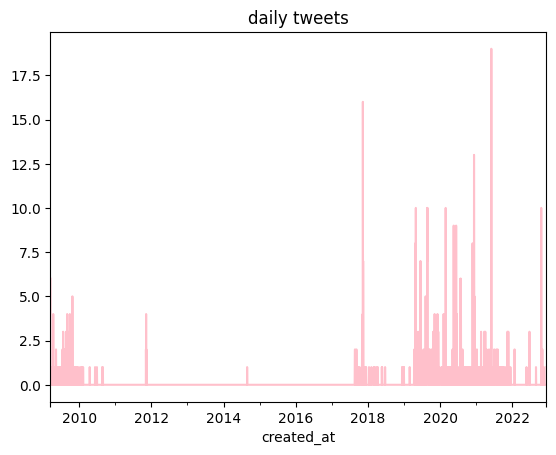

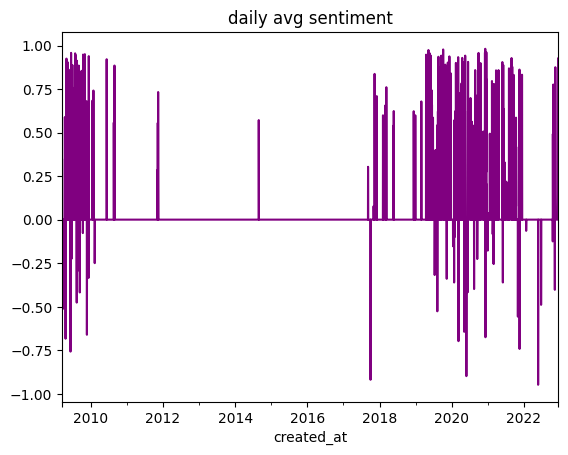

In [52]:
if matplotlib_available:
    try:
        daily["tweets"].plot(title="daily tweets",color="pink")
        plt.show()
        daily["avg_sentiment"].plot(title="daily avg sentiment", color="purple")
        plt.show()
    except Exception as e:
        print("plotting failed:", e)
else:
    print("matplotlib not available; skipping plots.")

### Exporting dataset

In [53]:
df.to_csv(data_dir / "posts_enriched.csv", index=False)

In [54]:
daily.reset_index().rename(columns={"created_at":"date"}).to_csv(data_dir / "daily_trends.csv", index=False)

In [55]:
if forecast is not None:
    forecast.reset_index().to_csv(data_dir / "tweets_forecast_7d.csv", index=False)

In [56]:
if topics_daily is not None:
    topics_daily.to_csv(data_dir / "topics_daily.csv", index=False)

In [57]:
print("wrote to:", data_dir.resolve())

wrote to: C:\Users\anahi\Semester 2\Social media\Project\new\Semester 2\Social media\Project\new\TaylorSwift13.csv


In [58]:
list(data_dir.glob("*.csv"))

[WindowsPath('Semester 2/Social media/Project/new/TaylorSwift13.csv/daily_trends.csv'),
 WindowsPath('Semester 2/Social media/Project/new/TaylorSwift13.csv/posts_enriched.csv'),
 WindowsPath('Semester 2/Social media/Project/new/TaylorSwift13.csv/topics_daily.csv')]

## Summary

In [59]:

sent_counts = df["sentiment_label"].value_counts().to_dict()
best_day = daily["tweets"].idxmax().date() if len(daily) else "N/A"
first_forecast = float(forecast.iloc[0,0]) if (forecast is not None and len(forecast)) else 0.0
n_topics_detected = int(n_topics) if 'n_topics' in globals() else 0
summary = f"""
# TaylorSwift13 — social media analysis summary
**total posts:** {len(df)}  
**sentiment distribution:** {sent_counts}  
**topics modeled:** {n_topics_detected}  
**highest-activity day:** {best_day}  
**7-day tweet volume forecast (next day):** {first_forecast:.1f}
"""
out_md = data_dir / "auto_report.md"
with open(out_md, "w", encoding="utf-8") as f:
    f.write(summary)

print("wrote:", out_md.resolve())

wrote: C:\Users\anahi\Semester 2\Social media\Project\new\Semester 2\Social media\Project\new\TaylorSwift13.csv\auto_report.md
